# Analyze sampling of the OPES Explore production simulation

## Preparation

In [1]:
%matplotlib widget

### Imports

In [2]:
# standard library
import logging
import os
from pathlib import Path    
import sys

# third-party packages
import cmasher as cmr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from scipy import stats, integrate
from tqdm.notebook import tqdm

# notebook
from IPython import display

# get absolute path to file's parent directory
dir_proj_base = Path(os.getcwd()).resolve().parents[1]
sys.path.insert(0, f"{dir_proj_base}/src")

# Internal dependencies
from utils.figure_style import set_style  # noqa: E402

### Logging and formatting

In [3]:
# notebook logger has DEBUG level
log = logging.getLogger("sampling_metad_notebook")
log.setLevel(logging.DEBUG)

# console handler
format = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(format)
log.addHandler(ch)

In [4]:
# set plotting style
set_style()

## Parameters

### System

In [5]:
# set thermal energy
TEMPERATURE_K: float = 300  # [K] # system temperature
KB = 8.314462618e-3  # [kJ/mol/K]
kbt = KB * TEMPERATURE_K  # [kJ/mol]


### Data location

In [6]:
# data input
data_dir = Path(f"/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Polyelectrolyte-Surface-Adsorption/data/sjobid_0-calcite-104surface-5nm_surface-8nm_vertical-1chain-PAcr-8mer-0Crb-0Ca-8Na-0Cl-300K-1bar-NVT/3-sampling-metadynamics")
fname = "COLVAR.data"

# data output
dir_fig = Path("figures/metadynamics")
dir_fig.mkdir(parents=True, exist_ok=True)


## Load data

In [7]:
def plumed_df(file: Path) -> pd.DataFrame:
    # input checking
    if not isinstance(file, Path):
        file = Path(file)
    if not file.parent.exists():
        raise FileNotFoundError(f"Directory {file.parent} does not exist")
    if not file.exists():
        raise FileExistsError(f"File {file} does not exist")

    # first line of file contains column names
    with open(str(file), encoding="utf8") as f:
        header = f.readline()
    header = header.split()[2:]  # remove "#!" FIELDS
    n_cols = len(header)

    # read in data
    df = pd.read_csv(
        str(file),
        names=header,
        comment="#",
        delim_whitespace=True,
        skipinitialspace=True,
        usecols=list(range(n_cols)),
    )
    return df


In [8]:
# read in data for base replica
file = data_dir / fname
data = plumed_df(file)

# # read in data for all replicas
# all_data = []
# for rep in range(8):
#     file = data_dir / f"replica_{rep:02d}/COLVAR.{rep}.data"
#     all_data.append(plumed_df(file))

### Exploratory data analysis

In [9]:
data.head()

time  dist_chain.x  dist_chain.y  dist_chain.z  metad.bias  metad.rbias  \
0   0.0     -0.328409     -1.244643      1.340236    0.000000     0.000000   
1   1.0     -0.295796     -1.223367      1.331203    0.000000     0.000000   
2   2.0     -0.272033     -1.245139      1.341934    0.911819     0.904295   
3   3.0     -0.304746     -1.212059      1.358177    1.326070     1.308506   
4   4.0     -0.285200     -1.220662      1.324542    2.083643     2.053551   

   metad.rct  rg_chain  cn_ca_co  dist_ca.x  dist_ca.y  dist_ca.z  \
0   0.000000  0.576196  4.666362  -4.998000  -2.696563   0.552875   
1   0.007524  0.561492  4.056941  -5.012044  -2.720610   0.566595   
2   0.017564  0.559051  3.879817  -4.984545  -2.722410   0.572661   
3   0.030091  0.562814  3.784018  -5.005813  -2.718768   0.565349   
4   0.046144  0.559133  4.277768  -5.022306  -2.712355   0.547766   

   upper_wall.bias  upper_wall.force2  lower_wall.bias  lower_wall.force2  
0              0.0                0.0              0.0                0.0  
1              0.0                0.0              0.0                0.0  
2              0.0                0.0              0.0                0.0  
3              0.0                0.0              0.0                0.0  
4              0.0                0.0              0.0                0.0

In [10]:
# print all column names
for col in data.columns:
    print(col)

log.info(f"Number of rows: {len(data)}")
log.info(f"Number of columns: {len(data.columns)}")

time
dist_chain.x
dist_chain.y
dist_chain.z
metad.bias
metad.rbias
metad.rct
rg_chain
cn_ca_co
dist_ca.x
dist_ca.y
dist_ca.z
upper_wall.bias
upper_wall.force2
lower_wall.bias
lower_wall.force2
2023-10-21 08:54:44,436 - sampling_metad_notebook - INFO - Number of rows: 500113
2023-10-21 08:54:44,436 - sampling_metad_notebook - INFO - Number of columns: 16


In [11]:
# find lower wall position by finding maximum z coordinate where lwall.bias > 0
lwall = data["lower_wall.bias"]
z_lwall = data["dist_chain.z"]
z_lwall_max = max(0, z_lwall[lwall > 0].max())
log.info(f"Lower wall position: {z_lwall_max:.2f} [nm]")

# find upper wall position by finding minimum z coordinate where uwall.bias > 0
uwall = data["upper_wall.bias"]
z_uwall = data["dist_chain.z"]
z_uwall_min = z_uwall[uwall > 0].min()
log.info(f"Upper wall position: {z_uwall_min:.2f} [nm]")


2023-10-21 08:54:44,446 - sampling_metad_notebook - INFO - Lower wall position: 0.00 [nm]
2023-10-21 08:54:44,448 - sampling_metad_notebook - INFO - Upper wall position: 2.80 [nm]


### Calculate statistical weight of each frame

In [12]:
def statistical_weight(df: pd.DataFrame, verbose: bool = False) -> None:
    """Calculate statistical weight of each configuration in-place.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing bias columns.
    verbose : bool, optional
        Whether to print statistical weight information, by default False
    """
    # get all columns ending in ".bias"
    cols = [col for col in df.columns if col.endswith(".bias")]
    # remove "metad.bias" if it exists
    if "metad.bias" in cols:
        cols.remove("metad.bias")
    # add "metad.rbias" if it exists
    if "metad.rbias" in df.columns:
        cols.append("metad.rbias")

    if verbose:
        print(f"Found {len(cols)} bias columns named {cols}")

    # calculate bias column as sum of all ".bias" columns
    df["bias"] = df[cols].sum(axis=1)
    # non-dimensionalize bias by kbt
    df["bias_nondim"] = (df["bias"] - np.nanmax(df["bias"])) / kbt
    # calculate statistical weight as boltzmann factor of bias
    df["weight"] = np.exp(df["bias_nondim"]) 
    # normalize weight column to be a probability distribution
    df["weight"] /= df["weight"].sum()
    # assert that weight column is a probability distribution
    assert np.isclose(df["weight"].sum(), 1.0)


In [13]:
# calculate overall bias
statistical_weight(data, verbose=True)

log.info("Calculating weight column from biases")
log.debug(f"(min, max) weight: ({np.nanmin(data['weight'])}, {np.nanmax(data['weight'])})")
log.debug(f"(0.25, 0.75) weight: ({np.nanpercentile(data['weight'], 25)}, {np.nanpercentile(data['weight'], 75)})")

# # calculate overall bias for all replicas
# for rep in range(8):
#     statistical_weight(all_data[rep], verbose=True)


Found 3 bias columns named ['upper_wall.bias', 'lower_wall.bias', 'metad.rbias']
2023-10-21 08:54:44,471 - sampling_metad_notebook - INFO - Calculating weight column from biases
2023-10-21 08:54:44,472 - sampling_metad_notebook - DEBUG - (min, max) weight: (8.75242836330293e-21, 0.007204982673347066)
2023-10-21 08:54:44,478 - sampling_metad_notebook - DEBUG - (0.25, 0.75) weight: (4.508304075674952e-09, 2.3358480116322908e-07)


## Visualize data

### Convergence of the bias potential

In [14]:
def fig_bias_dynamics(df: pd.DataFrame, fname: str) -> plt.Figure:
    fig = plt.figure(figsize=(9, 15))

    # CV: curve should show rapid sampling of the entire CV space
    ax1 = fig.add_subplot(321)
    ax1.set_xlabel("Time [ns]", labelpad=10)
    ax1.set_ylabel("$z$ [nm]", labelpad=10)
    ax1.set_title("Collective Variable", pad=10)
    ax1.scatter(df["time"]/1e3, df["dist_chain.z"], s=2, alpha=0.2)

    ax2 = fig.add_subplot(322)
    ax2.set_xlabel("Time [ns]", labelpad=10)
    ax2.set_ylabel("MetaD Bias [kJ/mol]", labelpad=10)
    ax2.set_title("MetaD Bias", pad=10)
    ax2.scatter(df["time"]/1e3, df["metad.bias"], s=2, alpha=0.2)

    # Lower wall bias: should hopefully be near zero for most of the simulation
    ax7 = fig.add_subplot(323)
    ax7.set_xlabel("Time [ns]", labelpad=10)
    ax7.set_ylabel("Bias [kJ/mol]", labelpad=10)
    ax7.set_title("Lower Wall Bias", pad=10)
    ax7.scatter(df["time"]/1e3, df["lower_wall.bias"], s=2, alpha=0.2)

    # Upper wall bias: should hopefully be near zero for most of the simulation 
    ax8 = fig.add_subplot(324)
    ax8.set_xlabel("Time [ns]", labelpad=10)
    ax8.set_ylabel("Bias [kJ/mol]", labelpad=10)
    ax8.set_title("Upper Wall Bias", pad=10)
    ax8.scatter(df["time"]/1e3, df["upper_wall.bias"], s=2, alpha=0.2)

    ax3 = fig.add_subplot(325)
    ax3.set_xlabel("Time [ns]", labelpad=10)
    ax3.set_ylabel("$c{(t)}$", labelpad=10)
    ax3.set_title("Quasi-Static Bias", pad=10)
    ax3.plot(df["time"]/1e3, df["metad.rct"], linewidth=3)
    
    ax2 = fig.add_subplot(326)
    ax2.set_xlabel("Time [ns]", labelpad=10)
    ax2.set_ylabel("MetaD R-Bias [kJ/mol]", labelpad=10)
    ax2.set_title("MetaD R-Bias", pad=10)
    ax2.scatter(df["time"]/1e3, df["metad.rbias"], s=2, alpha=0.2)


    # save figure
    fig.tight_layout()
    fig.savefig(f"{dir_fig}/{fname}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{dir_fig}/{fname}.pdf", dpi=1200, bbox_inches="tight", transparent=True)

    return fig


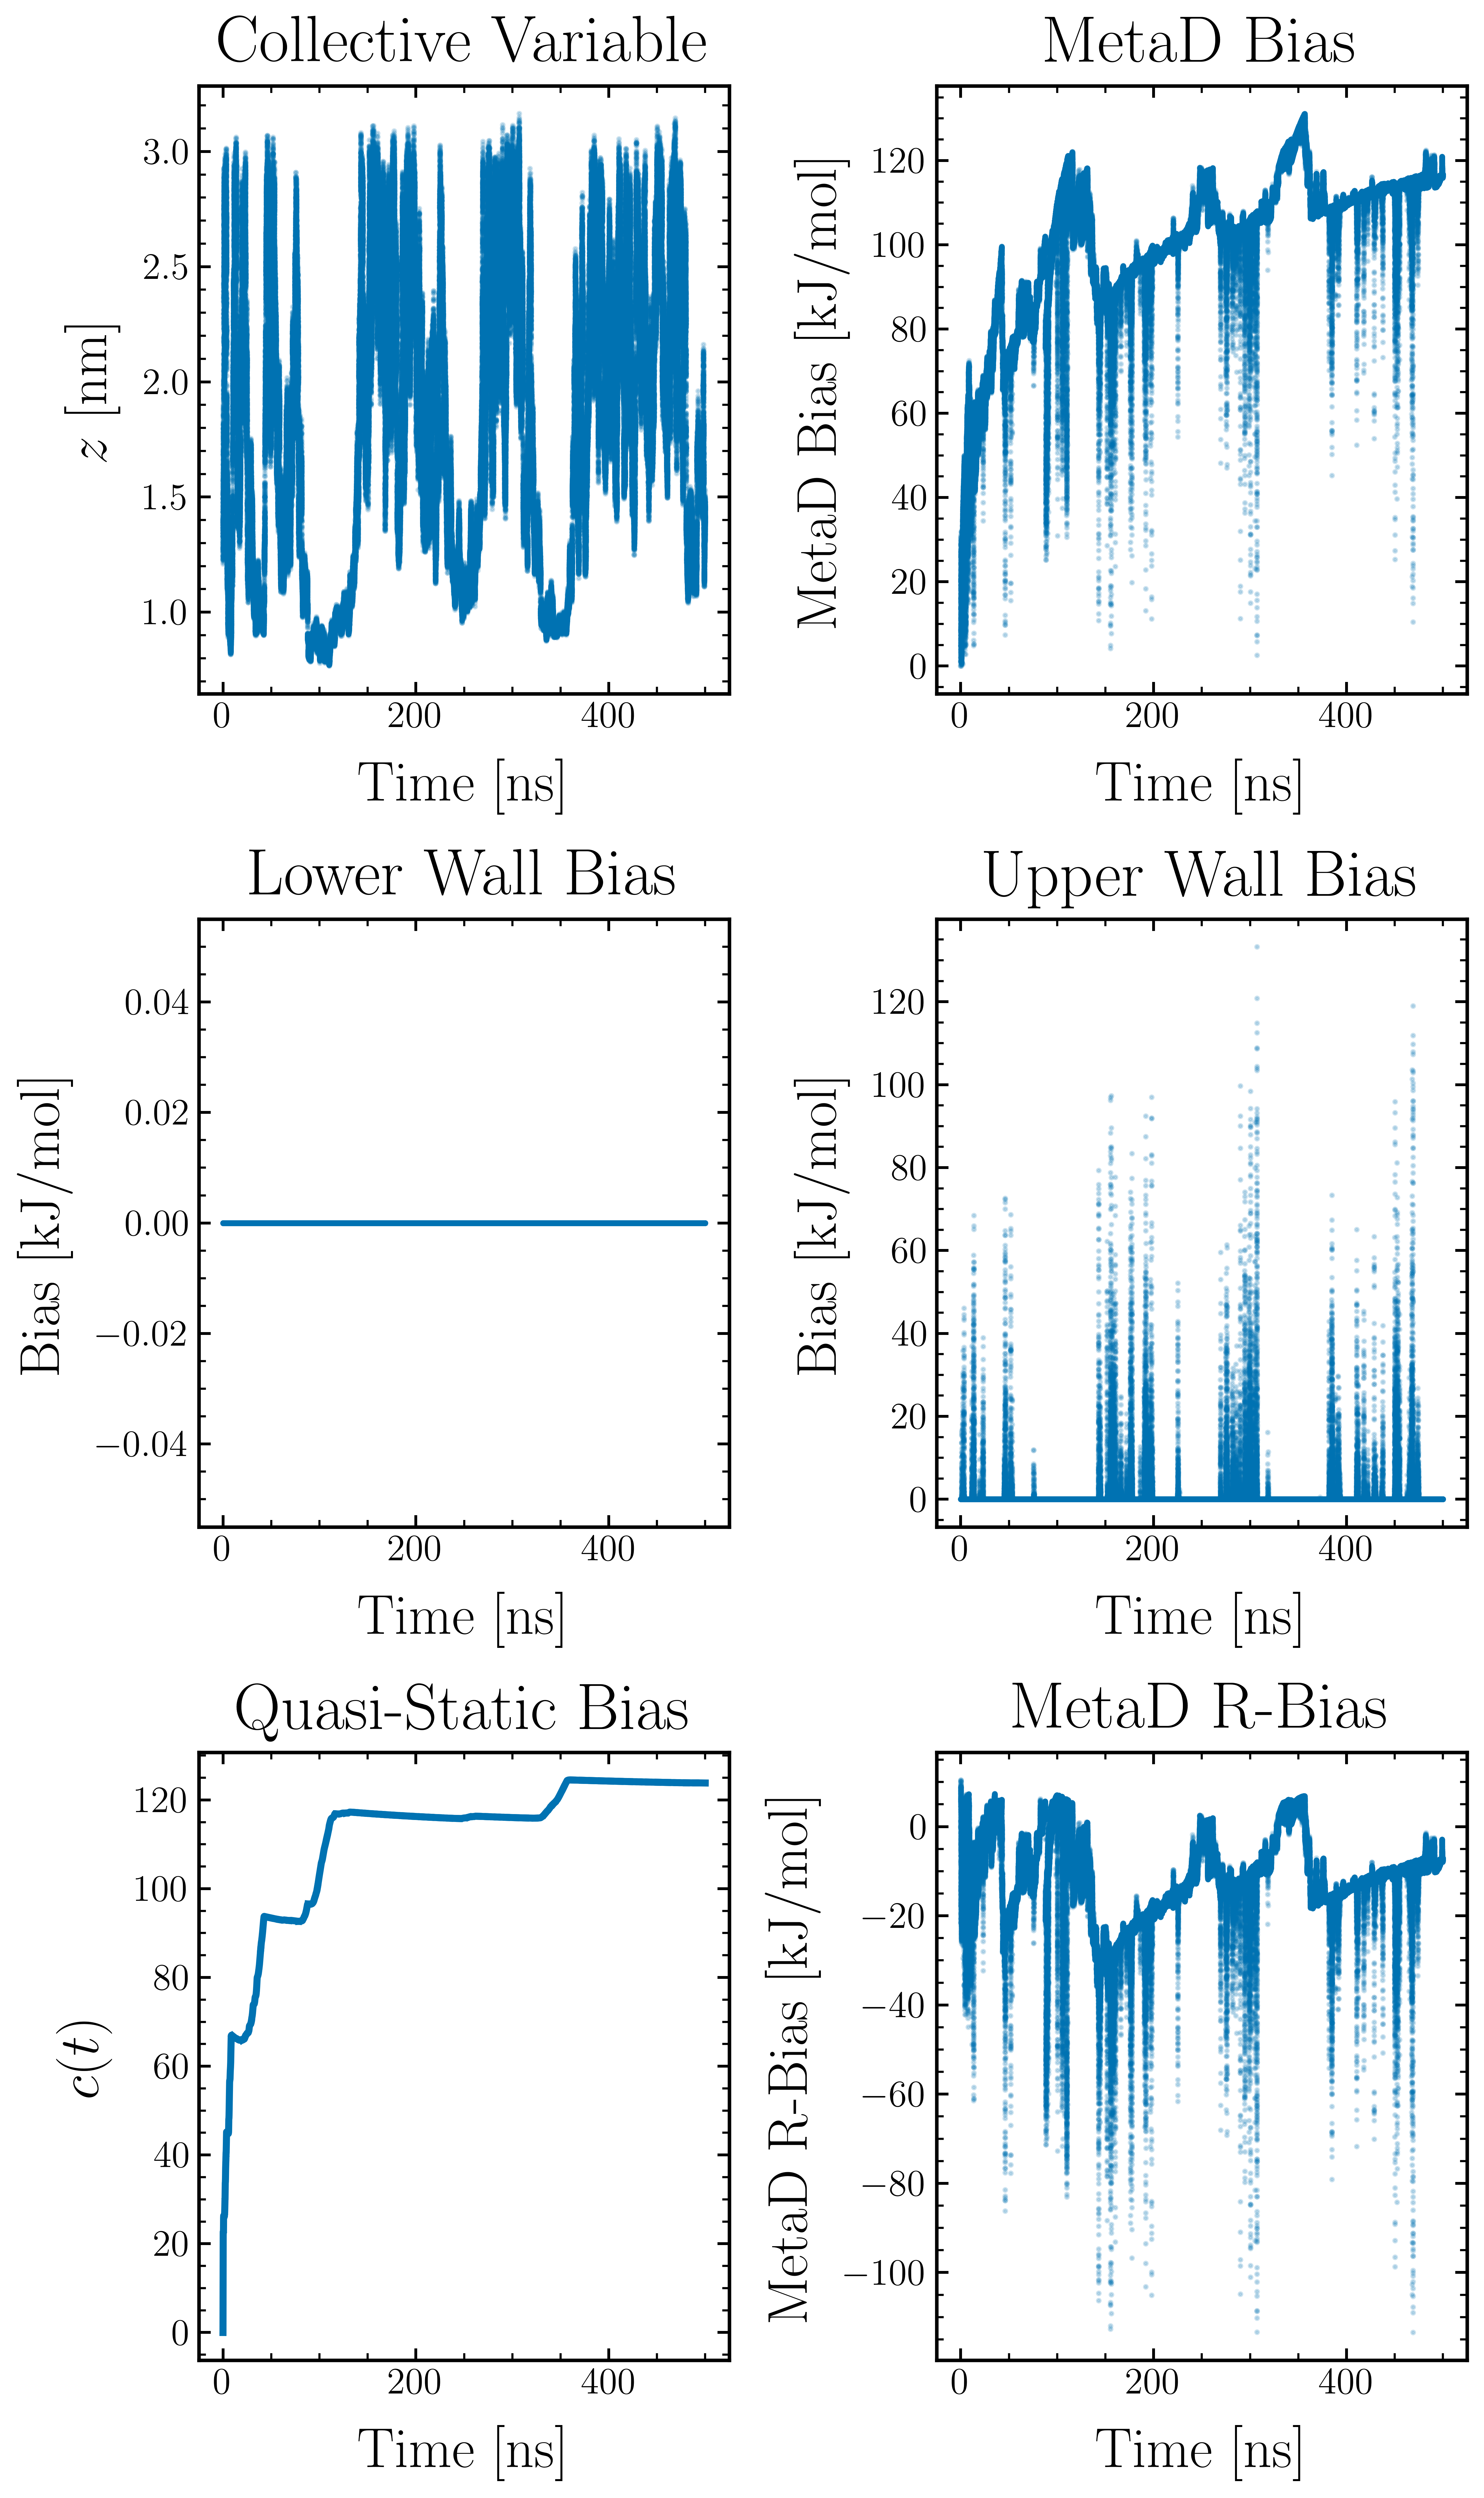

In [15]:
# plot bias dynamics for base replica
fname = "bias_dynamics"
fig = fig_bias_dynamics(data, fname)

# display figure
plt.close(fig)
display.Image(f"{dir_fig}/{fname}.png", width=900)


In [16]:
# # plot bias dynamics for all replicas
# for rep in range(8):
#     fname = f"bias_dynamics_replica_{rep:02d}"
#     fig = fig_bias_dynamics(all_data[rep], fname)
#     plt.close(fig)

In [17]:
# # plot the collective variable for all replicas
# fig = plt.figure(figsize=(20, 9))
# fname = "cv_dynamics"

# for i in range(8):
#     ax = fig.add_subplot(2, 4, i+1)
#     ax.set_xlabel("Time [ns]", labelpad=10)
#     ax.set_ylabel("$z$ [nm]", labelpad=10)
#     ax.set_title(f"Replica {i+1}", pad=10)
#     ax.scatter(all_data[i]["time"]/1e3, all_data[i]["dist_chain.z"], s=1, alpha=0.2)

# fig.tight_layout()

# # save figure
# fig.savefig(f"{dir_fig}/{fname}.png", dpi=600, bbox_inches="tight")
# fig.savefig(f"{dir_fig}/{fname}.pdf", dpi=1200, bbox_inches="tight", transparent=True)

# # display figure
# plt.close(fig)
# display.Image(f"{dir_fig}/{fname}.png", width=1200)


### Convergence of the free energy surface

In [18]:
# calculate free energy surface at the end of the simulation
bandwidth = 0.075
min_val = 0.8
max_val = 2.5
start_frame_perc = 0.30
cv = "dist_chain.z"

In [19]:
def fes_dist(
        x: np.ndarray, 
        weights: np.ndarray = None, 
        bandwidth: float = 0.1,
        min_val: float = None,
        max_val: float = None,
    ) -> tuple[np.ndarray, np.ndarray]:
    """Calculate the free energy surface for a given distance collective variable.

    Parameters
    ----------
    x : np.ndarray
        Array of distances.
    weights : np.ndarray, optional
        Array of weights, by default None
    bandwidth : float, optional
        Bandwidth for kernel density estimation, by default 0.1
    min_val : float, optional
        Minimum value of distance, by default None
    max_val : float, optional
        Maximum value of distance, by default None
    
    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Tuple of arrays of distances and free energies.

    Raises
    ------
    ValueError
        If `min_val` is not less than `max_val`.
    """
    # input checking
    if min_val is None:
        min_val = np.nanmin(x)
    if max_val is None:
        max_val = np.nanmax(x)
    if min_val >= max_val:
        raise ValueError(f"min_val ({min_val}) must be less than max_val ({max_val})")
    
    # calculate KDE of x weighted by weights
    x_grid = np.linspace(min_val, max_val, 300)
    kde = stats.gaussian_kde(x, weights=weights, bw_method=bandwidth)
    fes = - kde.logpdf(x_grid)

    # apply distance correction
    fes += 2 * np.log(x_grid)

    # set minimum to zero
    fes -= np.nanmin(fes)

    return x_grid, fes


In [20]:
def fe_diff(cv: np.ndarray, pmf: np.ndarray, lower_well: tuple[float, float], upper_well: tuple[float, float]) -> float:
    """
    Calculate the difference in free energy between the two wells.

    Parameters
    ----------
    cv : np.ndarray
        Array of collective variable values.
    pmf : np.ndarray
        Array of free energies as a function of collective variable, assumed to be unitless.
    lower_well : tuple[float, float]
        Tuple of (min, max) values for the lower well.
    upper_well : tuple[float, float]
        Tuple of (min, max) values for the upper well.
    
    Returns
    -------
    float
        Difference in free energy between the two wells. Unitless.
    """
    assert len(lower_well) == 2, "Lower well domain must have upper and lower bounds"
    assert len(upper_well) == 2, "Upper well domain must have upper and lower bounds"
    assert len(pmf) == len(cv), "PMF and CV must have the same size"

    # get indices of lower and upper wells
    lower_well_idx = np.where((cv > lower_well[0]) & (cv < lower_well[1]))
    upper_well_idx = np.where((cv > upper_well[0]) & (cv < upper_well[1]))

    # integrate boltzmann factors of wells to get probabilities
    boltzmann = np.exp(-pmf)
    prob_upper = integrate.simpson(boltzmann[upper_well_idx], x=cv[upper_well_idx])
    prob_lower = integrate.simpson(boltzmann[lower_well_idx], x=cv[lower_well_idx])

    # calculate free energy difference as log of ratio of probabilities
    delta_fe = - np.log(prob_lower / prob_upper)
    return delta_fe


In [22]:
# extract CV and weight data from base replica
df = data
start_time = df["time"].max() * start_frame_perc
log.info(f"Initial time for analysis: {start_time/1e3} ns")
df_fes_in = df[df["time"] >= (df["time"].max() * start_frame_perc)].copy()
arr_cv = df_fes_in[cv].to_numpy()
arr_weight = df_fes_in["weight"].to_numpy()

log.debug(f"Number of samples: {len(arr_cv)}")

# calculate FES for the base replica
x_grid, fes = fes_dist(
    arr_cv,
    weights=arr_weight,
    bandwidth=bandwidth, 
    min_val=min_val, 
    max_val=max_val, 
)

2023-10-21 08:55:54,866 - sampling_metad_notebook - INFO - Initial time for analysis: 150.0 ns
2023-10-21 08:55:54,901 - sampling_metad_notebook - DEBUG - Number of samples: 350001


### Convergence of the free energy surface

In [23]:
# calculate the free energy difference as a function of time
times = np.linspace(start_time + 1000, df["time"].max(), 200)
delta_fes = np.zeros(len(times))
lower_well = (0.7, 0.9)
upper_well = (2.0, 2.2)

for i, t in tqdm(enumerate(times), total=len(times)):
    # calculate PMF estimate at time t
    cv_data = df_fes_in[df_fes_in["time"] <= t][cv].to_numpy()
    weight_data = df_fes_in[df_fes_in["time"] <= t]["weight"].to_numpy()
    x, pmf = fes_dist(
            cv_data,
            weights=weight_data,
            bandwidth=bandwidth, 
            min_val=min_val, 
            max_val=max_val, 
        )

    # calculate free energy difference from PMF estimate
    delta_fes[i] = fe_diff(
        x,
        pmf,
        lower_well=lower_well,
        upper_well=upper_well,
    )


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_996241/2140670196.py:35: RuntimeWarning: divide by zero encountered in log
  delta_fe = - np.log(prob_lower / prob_upper)


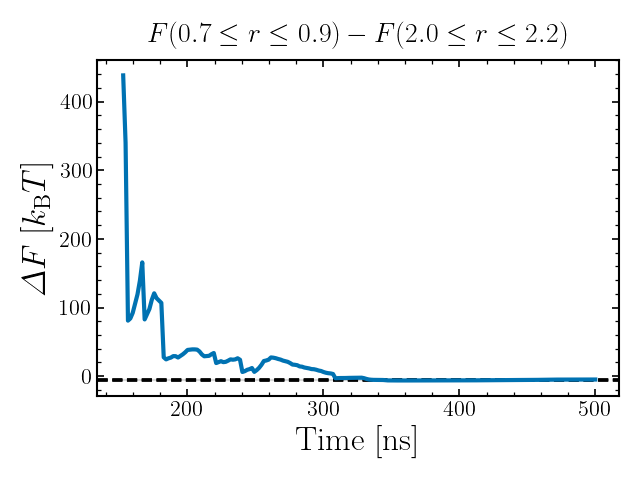

In [24]:
# plot the free energy difference as a function of time
fname = "pmf_diff_dynamics"

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Time [ns]")
ax.set_ylabel(r"$\Delta F$ [$k_\mathrm{B} T$]")
ax.set_title(
    f"$F({lower_well[0]} \leq r \leq {lower_well[1]}) - F({upper_well[0]} \leq r \leq {upper_well[1]})$", 
    y=1.03, 
    fontsize=20,
)

# add horizontal lines that are delta_fes[-1] +- 0.5
ax.axhline(delta_fes[-1] - 0.5, linestyle="--", color="k")
ax.axhline(delta_fes[-1] + 0.5, linestyle="--", color="k")
# fill in horizontal region between lines with opacity 0.2
ax.fill_between(
    [times[0]/1e3, times[-1]/1e3],
    delta_fes[-1] - 0.5, 
    delta_fes[-1] + 0.5, 
    alpha=0.1,
    color="k",
)
# plot delta F
ax.plot(times/1e3, delta_fes, linewidth=3)

# save figure
fig.tight_layout()
fig.savefig(f"{dir_fig}/{fname}.png", dpi=600, bbox_inches="tight")
fig.savefig(f"{dir_fig}/{fname}.pdf", dpi=1200, bbox_inches="tight", transparent=True)


### PMF Estimate

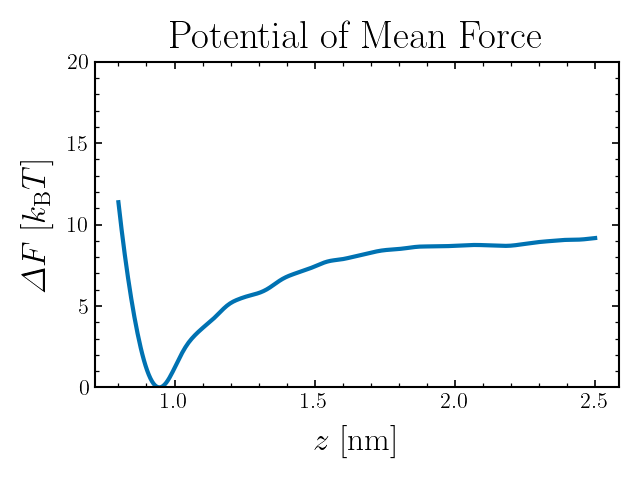

In [25]:
# plot free energy surface
ymax = 20
fname = "pmf"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Potential of Mean Force", pad=10)
ax.set_xlabel(r"$z$ [nm]", labelpad=10)
ax.set_ylabel(r"$\Delta F$ [$k_\mathrm{B}T$]", labelpad=10)
ax.set_ylim((0, ymax))

ax.plot(x_grid, fes, linewidth=3)

# save figure
fig.tight_layout()
fig.savefig(f"{dir_fig}/{fname}.png", dpi=600, bbox_inches="tight")
fig.savefig(f"{dir_fig}/{fname}.pdf", dpi=1200, bbox_inches="tight", transparent=True)


### Movie

In [27]:
# plot the free energy surface as a function of time as a movie
step = 500
fname = f"{dir_fig}/pmf_movie.mp4"
start_frame = int(start_frame_perc * len(data))

# setup figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"$z$ [nm]", labelpad=10)
ax.set_ylabel(r"$\Delta F$ [$k_\mathrm{B}T$]", labelpad=10)
ax.set_ylim((0, ymax))
ax.set_title("Potential of Mean Force", pad=10)

# initialize plot elements
idx = start_frame + step
curve = ax.plot(x_grid, np.zeros_like(x_grid), linewidth=3)
text = ax.text(0.5, 0.9, f"$t_f = ${data['time'][idx]/1e3:.2f} ns", transform=ax.transAxes, ha="center")

def animate(frame_num: int):
    global idx, start_frame
    global curve, text
    global data, cv, bandwidth, min_val, max_val

    # update curve
    _, fes = fes_dist(
        data[cv][start_frame:idx].to_numpy(),
        weights=data["weight"][start_frame:idx].to_numpy(),
        bandwidth=bandwidth, 
        min_val=min_val, 
        max_val=max_val,
    )
    curve[0].set_ydata(fes)

    # update text
    time = data["time"].loc[idx] / 1e3
    text.set_text(f"$t_f = $ {time:.1f} ns")

    # update index
    idx += step

    return curve, text


# animate
n_frames = (len(data) - start_frame) // step - 2
stop_frame = data[start_frame::step].index[-1]
log.debug(f"Number of frames: {n_frames}")
log.debug(f"Stop frame: {stop_frame}")
log.info(f"Creating animation")
anim = animation.FuncAnimation(
    fig, 
    animate, 
    blit=True,
    frames=n_frames,
)

# create tqdm progress bar
log.info(f"Saving animation as {fname}")
prog = tqdm(total=n_frames, desc="Saving animation", unit="frame", dynamic_ncols=True, colour="green")

# save animation as mp4 and output tqdm progress bar
anim.save(
    fname, 
    writer="ffmpeg", 
    fps=30, 
    dpi=300,
    progress_callback=lambda i, _: prog.update(1),
)
plt.close()
log.debug(f"Final time rendered: {data['time'].loc[idx] / 1e3:.2f} ns")
log.debug(f"Final simulation time: {data['time'].to_numpy()[-1] / 1e3:.2f} ns")

# display video in notebook
log.info(f"Displaying animation")
video = display.Video(fname, embed=True, width=700)
display.display(video)


2023-10-21 09:24:52,069 - sampling_metad_notebook - DEBUG - Number of frames: 698
2023-10-21 09:24:52,070 - sampling_metad_notebook - DEBUG - Stop frame: 500033
2023-10-21 09:24:52,070 - sampling_metad_notebook - INFO - Creating animation
2023-10-21 09:24:52,070 - sampling_metad_notebook - INFO - Saving animation as figures/metadynamics/pmf_movie.mp4


Saving animation:   0%|          | 0/698 [00:00<?, ?frame/s]

2023-10-21 09:45:28,573 - sampling_metad_notebook - DEBUG - Final time rendered: 499.92 ns
2023-10-21 09:45:28,574 - sampling_metad_notebook - DEBUG - Final simulation time: 500.00 ns
2023-10-21 09:45:28,574 - sampling_metad_notebook - INFO - Displaying animation
